In [32]:
import sys, torch

sys.path.append('/home/mdnikolaev/philurame/Experiments/QuantizationClip')
from q_utils import *

sys.path.append('/home/mdnikolaev/philurame/SDXL_METRICS')
from main import load_pipe

pipe = load_pipe(solver='DDIM', scheduler='LINEAR', cacher_quantizer='NONE', is_optimize=False, add_vae=True)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

- image with orig model

In [34]:
orig_img = pipe('a dog', num_inference_steps=50, generator=torch.Generator('cpu').manual_seed(42)).images[0]

- hadamard transform -> quantization -> hadamard transform -> dequantization

In [35]:
all_layers = get_linear_layers(pipe)
orig_weights = [i.weight.clone() for i in all_layers]

orig_layer = all_layers[0].weight.clone().detach().cpu()

# hadamard transform
for layer in all_layers:
  random_hadamard_transform_inplace(layer)

orig_hadamard   = all_layers[0].weight.clone().detach().cpu()

# quantize
all_quantized_layers = q_unet(pipe, nbits=8)

# dequantize
new_layers = dequantize_unet(pipe, all_quantized_layers)

dequantizing & inv. transform: 100%|██████████| 251/251 [00:05<00:00, 43.12it/s]


- sanity check

In [36]:
# sanity check

temp = orig_hadamard.clone()
inverse_random_hadamard_transform_inplace(temp)
print(f'{torch.norm(temp-orig_layer).item()}<1')

temp = all_quantized_layers[0].dequantize().clone().cpu()
inverse_random_hadamard_transform_inplace(temp)
print(f'{torch.norm(temp-orig_layer).item()}<1')

temp = new_layers[0].weight.clone().cpu()
print(f'{torch.norm(temp-orig_layer).item()}<1')

0.006381988525390625<1
0.10516357421875<1
0.10516357421875<1


- L2 errors of 8-bit quantization

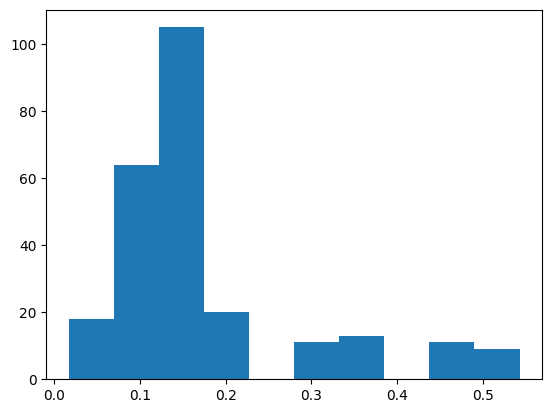

In [23]:
import matplotlib.pyplot as plt
errors = [torch.norm(orig_weights[i]-new_layers[i].weight).item() for i in range(len(orig_weights))]
plt.hist(errors);

- image with quantized model

In [37]:
quantized_img = pipe('a dog', num_inference_steps=50, generator=torch.Generator('cpu').manual_seed(42)).images[0]

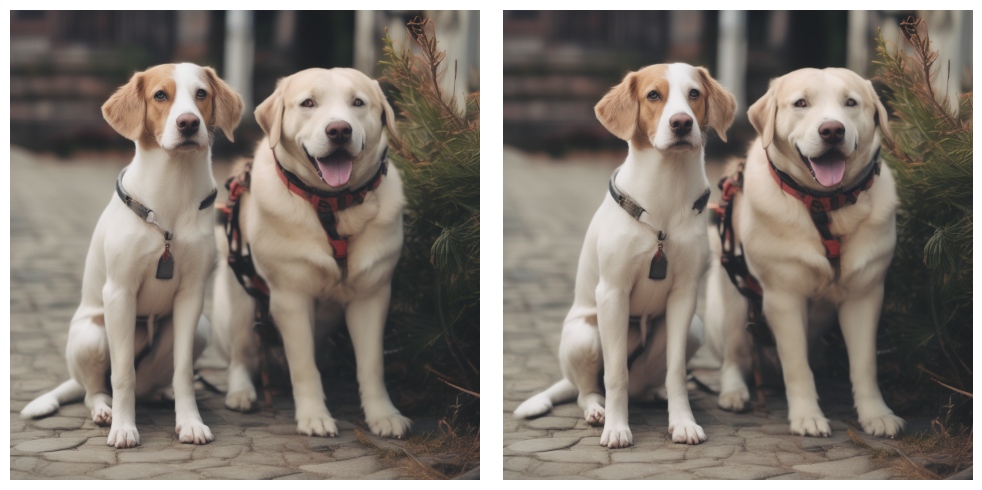

In [52]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(orig_img)
ax[1].imshow(quantized_img)
ax[0].axis('off')
ax[1].axis('off')
plt.tight_layout()